In [158]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import pandas as pd

In [2]:
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/covid.tfrecords' 
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/healthy.tfrecords' 

File ‘covid.tfrecords’ already there; not retrieving.

File ‘healthy.tfrecords’ already there; not retrieving.



### Ingest the healthy records

In [3]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/healthy.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

2023-10-28 19:50:03.285618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46594 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
def _parse_function(example_proto):
    feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_image(parsed['image_raw'])
    image = tf.reshape(image,[512,512,3])
    image = tf.image.adjust_contrast(image, 50 )
    print(parsed['covid'])
    return image,parsed['covid']

In [5]:
healthy = raw_dataset.map(_parse_function)
healthy

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

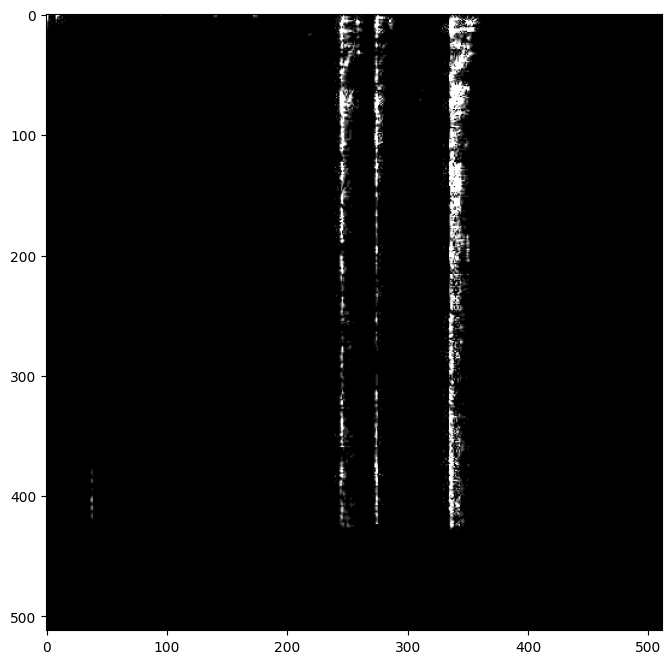

tf.Tensor(0.0, shape=(), dtype=float32)


In [6]:
for image_features in healthy.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Ingest the covid records

In [7]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/covid.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
covid = raw_dataset.map(_parse_function)

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


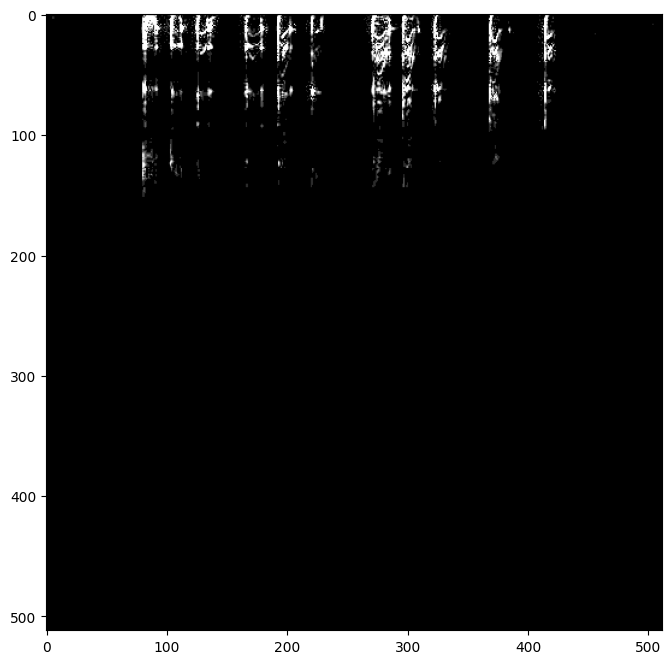

tf.Tensor(1.0, shape=(), dtype=float32)


In [9]:
for image_features in covid.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Concatenate the healthy and covid records into one tensor

In [106]:
data = covid.concatenate(healthy)
# normalization_layer = layers.Rescaling(1./255)
# data = data.map(lambda x, y: (normalization_layer(x), y))
length_dataset = data.reduce(0, lambda x,_: x+1).numpy()

In [107]:
length_dataset

12833

In [110]:
AUTOTUNE = tf.data.AUTOTUNE
data = data.shuffle(10000)
train = data.take(9000)
test = data.skip(9000).take(3833)


In [111]:
labels = []
for ele in test:
    labels.append(ele[1].numpy())
print(f'Number of COVIDs in Test Data: {labels.count(1)}')
print(f'Number of Healthy in Test Data: {labels.count(0)}')
labels = []
for ele in train:
    labels.append(ele[1].numpy())
print(f'Number of COVIDs in Train Data: {labels.count(1)}')
print(f'Number of Healthy in Train Data: {labels.count(0)}')

Number of COVIDs in Test Data: 308
Number of Healthy in Test Data: 3525
Number of COVIDs in Train Data: 791
Number of Healthy in Train Data: 8209


In [112]:
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(32)
test = test.cache().prefetch(buffer_size=AUTOTUNE).batch(32)

In [113]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def get_performance_stats(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    precision = hist.history['precision']
    val_precision = hist.history['val_precision']

    recall = hist.history['recall']
    val_recall = hist.history['val_recall']
    
    auc = hist.history['auc']
    val_auc = hist.history['val_auc']
    
    df = pd.DataFrame({'Accuracy':acc,'Val. Accuracy':val_acc,
                   'Loss':loss,'Val. Loss':val_loss,
                   'Precision':precision, 'Val. Precision':val_precision,
                   'Recall':recall, 'Val. Recall':val_recall,
                   'AUC':auc, 'Val. AUC':val_auc})
    
    df['F1'] = 2*df['Precision']*df['Recall']/(df['Precision'] + df['Recall'])
    
    df['Val. F1'] = 2*df['Val. Precision']*df['Val. Recall']/(df['Val. Precision'] + df['Val. Recall'])
    

    return df

### Test MobileNetV2

In [171]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [172]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 16, 16, 1280)      2257984   
 tional)                                                         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 16)        184336    
                                                                 
 global_average_pooling2d_1  (None, 16)                0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_18 (Flatten)        (None, 16)                0         
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 1)               

In [173]:
epochs = 5
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)

Epoch 1/5
282/282 [==============================] - 27s 85ms/step - loss: 1.5629 - cross entropy: 1.2573 - Brier score: 0.2462 - tp: 42.0000 - fp: 488.0000 - tn: 8812.0000 - fn: 906.0000 - accuracy: 0.8640 - precision: 0.0792 - recall: 0.0443 - auc: 0.5021 - prc: 0.0922 - val_loss: 0.8672 - val_cross entropy: 1.1366 - val_Brier score: 0.1005 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3537.0000 - val_fn: 296.0000 - val_accuracy: 0.9228 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5050 - val_prc: 0.0799
Epoch 2/5
282/282 [==============================] - 23s 82ms/step - loss: 1.4370 - cross entropy: 0.7519 - Brier score: 0.1317 - tp: 9.0000 - fp: 80.0000 - tn: 8103.0000 - fn: 808.0000 - accuracy: 0.9013 - precision: 0.1011 - recall: 0.0110 - auc: 0.5531 - prc: 0.1056 - val_loss: 0.8312 - val_cross entropy: 0.8377 - val_Brier score: 0.0959 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3537.0000 - val_fn: 296.0000 - val_accuracy: 0.9228 - val_precision

In [174]:
results_Mobile_Net = get_performance_stats(hist)

### Test VGG19

In [175]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)

base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [176]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 16)    73744     
                                                                 
 global_average_pooling2d_2  (None, 16)                0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_19 (Flatten)        (None, 16)                0         
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                     

In [177]:
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)

Epoch 1/5
    282/Unknown - 45s 154ms/step - loss: 1.5981 - cross entropy: 1.3642 - Brier score: 0.4370 - tp: 123.0000 - fp: 951.0000 - tn: 10769.0000 - fn: 990.0000 - accuracy: 0.8487 - precision: 0.1145 - recall: 0.1105 - auc: 0.5457 - prc: 0.1007

2023-10-28 21:58:50.613826: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3723856027690665421
2023-10-28 21:58:50.613911: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12967038015471803699


282/282 [==============================] - 69s 241ms/step - loss: 1.5981 - cross entropy: 1.3642 - Brier score: 0.4370 - tp: 123.0000 - fp: 951.0000 - tn: 10769.0000 - fn: 990.0000 - accuracy: 0.8487 - precision: 0.1145 - recall: 0.1105 - auc: 0.5457 - prc: 0.1007 - val_loss: 0.8726 - val_cross entropy: 0.8632 - val_Brier score: 0.1306 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 3537.0000 - val_fn: 295.0000 - val_accuracy: 0.9230 - val_precision: 1.0000 - val_recall: 0.0034 - val_auc: 0.5496 - val_prc: 0.1059
Epoch 2/5
282/282 [==============================] - 68s 240ms/step - loss: 1.4462 - cross entropy: 0.8607 - Brier score: 0.1786 - tp: 51.0000 - fp: 261.0000 - tn: 7922.0000 - fn: 766.0000 - accuracy: 0.8859 - precision: 0.1635 - recall: 0.0624 - auc: 0.5622 - prc: 0.1165 - val_loss: 0.8139 - val_cross entropy: 0.8444 - val_Brier score: 0.1617 - val_tp: 1.0000 - val_fp: 8.0000 - val_tn: 3529.0000 - val_fn: 295.0000 - val_accuracy: 0.9209 - val_precision: 0.1111 - val_recall: 0

In [178]:
results_VGG19 = get_performance_stats(hist)

### Test Efficient Net B2

In [179]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.efficientnet.EfficientNetB2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
)


base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

31790344/31790344 [==============================] - 1s 0us/step


In [180]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 conv2d_21 (Conv2D)          (None, None, None, 16)    202768    
                                                                 
 global_average_pooling2d_2  (None, 16)                0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_20 (Flatten)        (None, 16)                0         
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)               

In [181]:
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)

Epoch 1/5


2023-10-28 22:03:59.223688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


282/282 [==============================] - 60s 189ms/step - loss: 1.5503 - cross entropy: 0.9851 - Brier score: 0.2114 - tp: 65.0000 - fp: 504.0000 - tn: 11216.0000 - fn: 1048.0000 - accuracy: 0.8791 - precision: 0.1142 - recall: 0.0584 - auc: 0.5414 - prc: 0.0997 - val_loss: 0.9040 - val_cross entropy: 0.9375 - val_Brier score: 0.1151 - val_tp: 3.0000 - val_fp: 6.0000 - val_tn: 3531.0000 - val_fn: 293.0000 - val_accuracy: 0.9220 - val_precision: 0.3333 - val_recall: 0.0101 - val_auc: 0.5533 - val_prc: 0.1028
Epoch 2/5
282/282 [==============================] - 52s 183ms/step - loss: 1.4838 - cross entropy: 1.0109 - Brier score: 0.1940 - tp: 66.0000 - fp: 490.0000 - tn: 7693.0000 - fn: 751.0000 - accuracy: 0.8621 - precision: 0.1187 - recall: 0.0808 - auc: 0.5598 - prc: 0.1093 - val_loss: 0.8103 - val_cross entropy: 1.0648 - val_Brier score: 0.1830 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 3533.0000 - val_fn: 294.0000 - val_accuracy: 0.9223 - val_precision: 0.3333 - val_recall: 0.006

In [182]:
results_ENB2 = get_performance_stats(hist)

### Test Inception V3

In [183]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)


base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

87910968/87910968 [==============================] - 1s 0us/step


In [184]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 conv2d_116 (Conv2D)         (None, None, None, 16)    294928    
                                                                 
 global_average_pooling2d_2  (None, 16)                0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_21 (Flatten)        (None, 16)                0         
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 1)               

In [185]:
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)

Epoch 1/5
282/282 [==============================] - 36s 108ms/step - loss: 1.7003 - cross entropy: 1.2053 - Brier score: 1.0729 - tp: 61.0000 - fp: 341.0000 - tn: 11379.0000 - fn: 1052.0000 - accuracy: 0.8915 - precision: 0.1517 - recall: 0.0548 - auc: 0.5375 - prc: 0.1027 - val_loss: 0.9217 - val_cross entropy: 1.1121 - val_Brier score: 0.0997 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3537.0000 - val_fn: 296.0000 - val_accuracy: 0.9228 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5069 - val_prc: 0.0800
Epoch 2/5
282/282 [==============================] - 27s 94ms/step - loss: 1.4984 - cross entropy: 0.9537 - Brier score: 0.1189 - tp: 2.0000 - fp: 16.0000 - tn: 8167.0000 - fn: 815.0000 - accuracy: 0.9077 - precision: 0.1111 - recall: 0.0024 - auc: 0.5262 - prc: 0.0980 - val_loss: 0.8809 - val_cross entropy: 1.0581 - val_Brier score: 0.0987 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3537.0000 - val_fn: 296.0000 - val_accuracy: 0.9228 - val_precis

In [186]:
results_Inception = get_performance_stats(hist)

### Test Efficient Net B7

In [187]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
)


base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

258076736/258076736 [==============================] - 3s 0us/step


In [188]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 conv2d_117 (Conv2D)         (None, None, None, 16)    368656    
                                                                 
 global_average_pooling2d_2  (None, 16)                0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_22 (Flatten)        (None, 16)                0         
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 1)               

In [189]:
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)

Epoch 1/5


2023-10-28 22:11:12.372245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


282/282 [==============================] - 219s 725ms/step - loss: 1.5714 - cross entropy: 1.0751 - Brier score: 0.2486 - tp: 79.0000 - fp: 607.0000 - tn: 11113.0000 - fn: 1034.0000 - accuracy: 0.8721 - precision: 0.1152 - recall: 0.0710 - auc: 0.5353 - prc: 0.0977 - val_loss: 0.9319 - val_cross entropy: 0.7720 - val_Brier score: 0.0913 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 3535.0000 - val_fn: 296.0000 - val_accuracy: 0.9223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5626 - val_prc: 0.1050
Epoch 2/5
282/282 [==============================] - 200s 709ms/step - loss: 1.4726 - cross entropy: 0.9662 - Brier score: 0.2076 - tp: 88.0000 - fp: 555.0000 - tn: 7628.0000 - fn: 729.0000 - accuracy: 0.8573 - precision: 0.1369 - recall: 0.1077 - auc: 0.5612 - prc: 0.1155 - val_loss: 0.8762 - val_cross entropy: 0.8650 - val_Brier score: 0.1537 - val_tp: 27.0000 - val_fp: 156.0000 - val_tn: 3381.0000 - val_fn: 269.0000 - val_accuracy: 0.8891 - val_precision: 0.1475 - 

In [190]:
results_ENB7 = get_performance_stats(hist)

### Compare Results

In [192]:
import seaborn as sns

In [207]:
sns.set(rc = {'axes.facecolor':'white',
              "axes.edgecolor":'black',    
            "xtick.bottom":True,
            "xtick.top":False,
            "ytick.left":True,
            "ytick.right":False,
            "axes.linewidth":0.2,
            "xtick.major.width":0.2,
            "ytick.major.width":0.2,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2,
            "font.size":10,
            "axes.labelsize":10,
            "axes.titlesize":10,
            "xtick.labelsize":10,
            "ytick.labelsize":10,
            "legend.fontsize":10,
            "legend.title_fontsize":10,
            "lines.linewidth":1.0,
            "patch.linewidth":0.2,
            "patch.edgecolor":'black',
            "patch.force_edgecolor":True,
            "xtick.major.size":3,
            "ytick.major.size":3,
            "xtick.minor.size":1,
            "ytick.minor.size":1,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2})

In [246]:
results_Mobile_Net['Model'] = 'MobileNetV2'
results_Mobile_Net= results_Mobile_Net.reset_index()
results_ENB2['Model'] = 'EfficientNetB2'
results_ENB2 = results_ENB2.reset_index()
results_Inception['Model'] = 'InceptionV3'
results_Inception = results_Inception.reset_index()
results_ENB7['Model'] ='EfficientNetB7'
results_ENB7= results_ENB7.reset_index()
results_VGG19['Model'] = 'VGG19'
results_VGG19 = results_VGG19.reset_index()

results =pd.concat([results_Mobile_Net,results_ENB2, results_Inception, results_ENB7, results_VGG19])

ValueError: cannot insert level_0, already exists

In [255]:
results_max = results.groupby(by='Model').mean()
results['index'] = results['index'] + 1

Text(0, 0.5, 'Validation AUC')

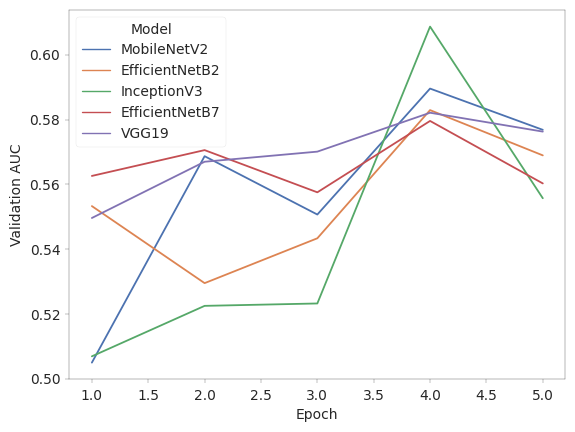

In [256]:
 sns.lineplot(data=results, x='index', y='Val. AUC',hue='Model',linewidth=1.3)
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')

In [257]:
results_max = results_max.reset_index()

In [262]:
AUC = results_max[['Model','AUC','Val. AUC']]

In [263]:
AUC = pd.melt(AUC,id_vars='Model')
AUC = AUC.replace({'AUC':'Train','Val. AUC':'Validation'})
AUC = AUC.rename({'variable':'Train/Validation'},axis=1)
AUC

,Model,Train/Validation,value
0,EfficientNetB2,Train,0.566513
1,EfficientNetB7,Train,0.554648
2,InceptionV3,Train,0.547110
3,MobileNetV2,Train,0.559877
4,VGG19,Train,0.576744
5,EfficientNetB2,Validation,0.555600
6,EfficientNetB7,Validation,0.566114
7,InceptionV3,Validation,0.543406
8,MobileNetV2,Validation,0.558147
9,VGG19,Validation,0.569017


<Figure size 1000x600 with 0 Axes>

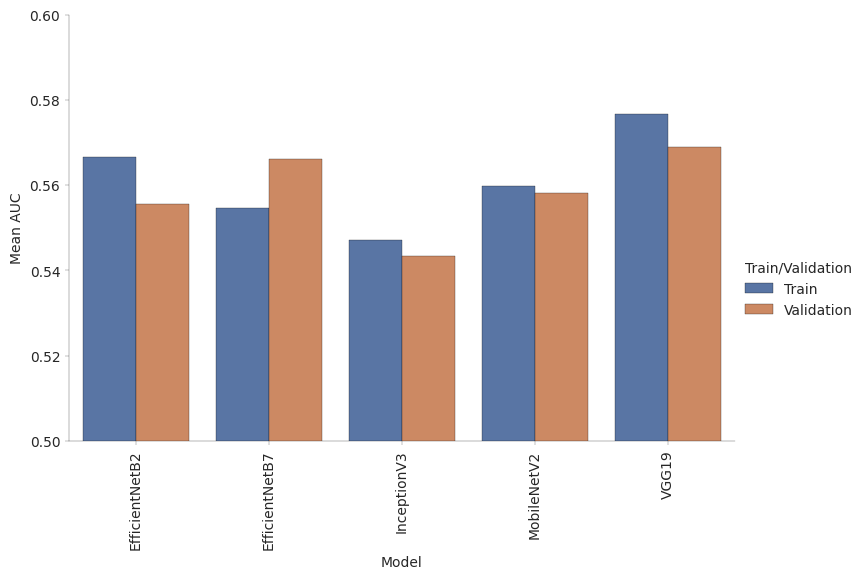

In [264]:
plt.figure(figsize=(5,3),dpi=200)
sns.catplot(data=AUC,x='Model',y='value',hue='Train/Validation',kind='bar',aspect=1.5)
plt.xticks(rotation=90)
plt.ylabel('Mean AUC')
plt.ylim([0.5,0.6])
plt.show()